# Sequential Neuron Elimination via Approximate Dynamic Programming (ADP)

This notebook implements the computational experiment for **single-hidden-layer ReLU neuron pruning** using:

- Greedy baselines (magnitude, one-shot loss ranking, single-step loss greedy)
- **Tabular Q-learning ADP** with **quantized states** \($|S_t|, \lfloor (\mathcal{L}(S_t)-\mathcal{L}_0)/\delta \rfloor$\) and **macro-actions** (pruning rules)

We compare methods under a **maximum-loss constraint**:
$$
\mathcal{L}(S) \le \mathcal{L}_0 + \epsilon.
$$

> The code is designed to run quickly on a laptop for small-to-moderate \(K\).

In [1]:
# Imports
import numpy as np
import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

plt.rcParams['figure.dpi'] = 120


## 1. Problem setup: data + single-hidden-layer ReLU network

We create a synthetic regression dataset:
- Inputs: $(x \sim \mathrm{Unif}([-1,1]^d))$
- Targets generated by a "teacher" ReLU network + Gaussian noise

We then treat the trained/frozen model as the pruning target.
For simplicity (and full reproducibility), we use the teacher weights as the frozen network weights.


In [2]:
def relu(z):
    return np.maximum(z, 0.0)

def forward(X, W, b, v, S):
    S = np.asarray(S, dtype=np.int64)

    # Silence BLAS/Accelerate floating-point warning noise
    with np.errstate(over='ignore', divide='ignore', invalid='ignore'):
        Z = X @ W[:, S] + b[S]
        H = np.maximum(Z, 0.0)
        yhat = H @ v[S]

    # Hard check: if anything is actually wrong, fail loudly
    if not (np.isfinite(Z).all() and np.isfinite(yhat).all()):
        raise FloatingPointError("Non-finite values detected in forward()")

    return yhat

def mse_loss(X, y, W, b, v, S):
    yhat = forward(X, W, b, v, S)
    return float(np.mean((yhat - y) ** 2))


In [3]:
# Synthetic data + frozen network parameters
def make_synthetic_problem(N=50, d=10, K=500, noise_std=0.05, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.uniform(-1, 1, size=(N, d)).astype(np.float64)

    W = (rng.normal(size=(d, K)) * 0.8).astype(np.float64)
    b = (rng.normal(size=(K,)) * 0.1).astype(np.float64)
    v = (rng.normal(size=(K,)) * 0.8).astype(np.float64)

    y_clean = forward(X, W, b, v, np.arange(K))
    y = y_clean + noise_std * rng.normal(size=(N,)).astype(np.float64)
    return X, y, W, b, v

# Example instance
N, d, K = 100, 10, 1000
X, y, W, b, v = make_synthetic_problem(N=N, d=d, K=K, noise_std=0.05, seed=GLOBAL_SEED)

S_full = list(range(K))
L0 = mse_loss(X, y, W, b, v, S_full)
L0


0.002142110819109184

## 2. Greedy baselines

- **Greedy magnitude-based**: sort by $(|v_k|\|w_k\|)$ and prune in that order, stopping when constraint violated.
- **Greedy one-shot loss ranking**: compute $\Delta_k^{(0)} = \mathcal{L}([K]\setminus\{k\})-\mathcal{L}_0$ once, rank, prune.
- **Greedy single-step loss**: recompute marginal loss increase at each step and prune the best immediate one (expensive).


In [4]:
def greedy_magnitude(W, b, v, X, y, eps):
    K = W.shape[1]
    S = list(range(K))
    L0 = mse_loss(X, y, W, b, v, S)
    scores = np.array([abs(v[k]) * np.linalg.norm(W[:, k]) for k in range(K)])
    for k in np.argsort(scores):
        if k not in S:
            continue
        S_new = [i for i in S if i != k]
        if mse_loss(X, y, W, b, v, S_new) <= L0 + eps:
            S = S_new
        else:
            break
    return S

def greedy_oneshot_loss(W, b, v, X, y, eps):
    K = W.shape[1]
    full = list(range(K))
    L0 = mse_loss(X, y, W, b, v, full)

    delta0 = np.zeros(K)
    for k in range(K):
        S_k = [i for i in full if i != k]
        delta0[k] = mse_loss(X, y, W, b, v, S_k) - L0

    S = full[:]
    for k in np.argsort(delta0):
        if k not in S:
            continue
        S_new = [i for i in S if i != k]
        if mse_loss(X, y, W, b, v, S_new) <= L0 + eps:
            S = S_new
        else:
            break
    return S

def greedy_singlestep_loss(W, b, v, X, y, eps):
    K = W.shape[1]
    S = list(range(K))
    L0 = mse_loss(X, y, W, b, v, S)

    while len(S) > 1:
        L = mse_loss(X, y, W, b, v, S)
        deltas = []
        for k in S:
            S_k = [i for i in S if i != k]
            deltas.append((mse_loss(X, y, W, b, v, S_k) - L, k))
        deltas.sort()
        _, kstar = deltas[0]

        S_new = [i for i in S if i != kstar]
        if mse_loss(X, y, W, b, v, S_new) <= L0 + eps:
            S = S_new
        else:
            break
    return S


## 3. ADP with quantized states + macro-actions (tabular Q-learning, cost minimization)

### Quantized state
We aggregate the pruning state into:
$$
\tilde X_t = (m_t, b_t),\quad m_t = |S_t|,\quad
b_t = \left\lfloor \frac{\mathcal{L}(S_t)-\mathcal{L}_0}{\delta} \right\rfloor.
$$

### Macro-actions
Actions are pruning **rules**, not neurons:
1. prune least importance score $(|v_k|\|w_k\|)$
2. prune 2nd least importance score
3. prune least one-shot loss proxy $\Delta_k^{(0)}$
4. prune a random remaining neuron

### Stage cost
$$
g_t = \mathcal{L}(S_{t+1}) - \mathcal{L}(S_t) \ge 0.
$$
We learn a **cost-to-go** table $(Q(\tilde x, a))$ and act by $\arg\min_a Q$.


In [5]:
def precompute_scores(W, b, v, X, y):
    K = W.shape[1]
    full = list(range(K))
    L0 = mse_loss(X, y, W, b, v, full)

    s = np.array([abs(v[k]) * np.linalg.norm(W[:, k]) for k in range(K)])

    delta0 = np.zeros(K)
    for k in range(K):
        S_k = [i for i in full if i != k]
        delta0[k] = mse_loss(X, y, W, b, v, S_k) - L0

    return L0, s, delta0

def select_neuron_by_macro_action(a, S, s, delta0):
    if a == 4:
        return random.choice(S)
    if a == 1 or a == 2:
        ordered = sorted(S, key=lambda k: s[k])
        idx = 0 if a == 1 else 1
        idx = min(idx, len(ordered) - 1)
        return ordered[idx]
    if a == 3:
        return min(S, key=lambda k: delta0[k])
    raise ValueError("Unknown action")

def qlearn_macro_actions_cost(W, b, v, X, y, eps,
                             delta_bin=0.002, episodes=400,
                             alpha=0.25, gamma=0.95, eps_greedy=0.2,
                             infeasible_penalty=1.0,
                             seed=0):
    random.seed(seed)
    np.random.seed(seed)

    K = W.shape[1]
    full = list(range(K))
    L0, s, delta0 = precompute_scores(W, b, v, X, y)

    A = [1, 2, 3, 4]
    Q = defaultdict(lambda: np.zeros(len(A), dtype=float))

    def state_key(S, L):
        m = len(S)
        gap = max(0.0, L - L0)
        bidx = int(np.floor(gap / delta_bin))
        return (m, bidx)

    # Training episodes
    for ep in range(episodes):
        S = full[:]
        L = mse_loss(X, y, W, b, v, S)

        while len(S) > 1 and L <= L0 + eps:
            skey = state_key(S, L)

            # epsilon-greedy for minimization (pick smallest Q)
            if random.random() < eps_greedy:
                ai = random.randrange(len(A))
            else:
                ai = int(np.argmin(Q[skey]))
            a = A[ai]

            k = select_neuron_by_macro_action(a, S, s, delta0)
            S_new = [i for i in S if i != k]
            L_new = mse_loss(X, y, W, b, v, S_new)

            # Infeasible => large cost penalty, terminate
            if L_new > L0 + eps:
                g = infeasible_penalty
                Q[skey][ai] += alpha * (g - Q[skey][ai])
                break

            # Stage cost
            g = (L_new - L)
            skey2 = state_key(S_new, L_new)

            td_target = g + gamma * np.min(Q[skey2])
            Q[skey][ai] += alpha * (td_target - Q[skey][ai])

            S, L = S_new, L_new

    # Greedy rollout under learned Q
    def rollout():
        S = full[:]
        L = mse_loss(X, y, W, b, v, S)
        traj = [(len(S), L)]
        while len(S) > 1 and L <= L0 + eps:
            skey = state_key(S, L)
            ai = int(np.argmin(Q[skey]))
            a = A[ai]
            k = select_neuron_by_macro_action(a, S, s, delta0)
            S_new = [i for i in S if i != k]
            L_new = mse_loss(X, y, W, b, v, S_new)
            if L_new > L0 + eps:
                break
            S, L = S_new, L_new
            traj.append((len(S), L))
        return S, L, traj

    S_final, L_final, traj = rollout()
    return S_final, L_final, L0, Q, traj


## 4. Run a single trial + inspect pruning trajectories

We run all methods and plot loss vs remaining width.


In [6]:
# Hyperparameters for pruning
eps = 0.5          # allowable loss increase
delta_bin = 0.002   # quantization bin width for loss gap

# Baselines
S_mag = greedy_magnitude(W, b, v, X, y, eps)
S_one = greedy_oneshot_loss(W, b, v, X, y, eps)
S_step = greedy_singlestep_loss(W, b, v, X, y, eps)

L_mag = mse_loss(X, y, W, b, v, S_mag)
L_one = mse_loss(X, y, W, b, v, S_one)
L_step = mse_loss(X, y, W, b, v, S_step)

# ADP (tabular Q-learning)
S_adp, L_adp, L0_check, Q, traj_adp = qlearn_macro_actions_cost(
    W, b, v, X, y, eps,
    delta_bin=delta_bin,
    episodes=500,
    alpha=0.25,
    gamma=0.95,
    eps_greedy=0.2,
    infeasible_penalty=1.0,
    seed=GLOBAL_SEED
)

results_single = pd.DataFrame([
    {"Method": "Greedy magnitude", "Remaining width": len(S_mag), "Final loss": L_mag},
    {"Method": "Greedy one-shot loss", "Remaining width": len(S_one), "Final loss": L_one},
    {"Method": "Greedy single-step loss", "Remaining width": len(S_step), "Final loss": L_step},
    {"Method": "ADP (Q-learning macro)", "Remaining width": len(S_adp), "Final loss": L_adp},
])

results_single


,Method,Remaining width,Final loss
0,Greedy magnitude,884,0.499535
1,Greedy one-shot loss,888,0.443901
2,Greedy single-step loss,626,0.490019
3,ADP (Q-learning macro),883,0.478396


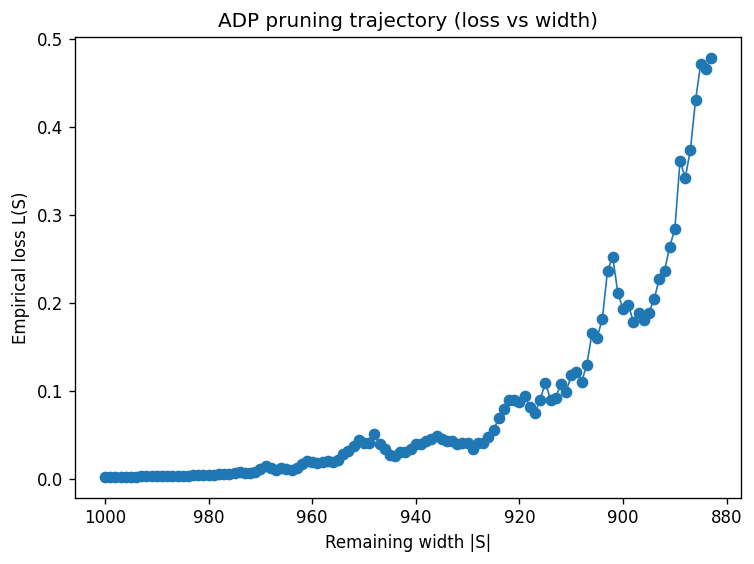

In [7]:
# Plot loss vs remaining width for ADP trajectory (and baseline endpoints)
widths, losses = zip(*traj_adp)

plt.figure()
plt.plot(widths, losses, marker='o', linewidth=1)
plt.axhline(L0 + eps, linestyle='--', linewidth=1)
plt.gca().invert_xaxis()
plt.xlabel("Remaining width |S|")
plt.ylabel("Empirical loss L(S)")
plt.title("ADP pruning trajectory (loss vs width)")
plt.tight_layout()
plt.savefig("ADP_pruning_trajectory.pdf")
plt.show()


## 5. Multiple trials + summary table + plots

We repeat the experiment across multiple random seeds and summarize:
- mean/std of remaining width
- mean/std of final loss

This is what you can copy into your IEEE paper's Results table.


In [8]:
def run_trial(seed, N=100, d=10, K=50, noise_std=0.05,
              eps=0.01, delta_bin=0.002,
              adp_episodes=400):
    X, y, W, b, v = make_synthetic_problem(N=N, d=d, K=K, noise_std=noise_std, seed=seed)
    full = list(range(K))
    L0 = mse_loss(X, y, W, b, v, full)

    # Baselines
    S_mag = greedy_magnitude(W, b, v, X, y, eps)
    S_one = greedy_oneshot_loss(W, b, v, X, y, eps)
    S_step = greedy_singlestep_loss(W, b, v, X, y, eps)

    # ADP
    S_adp, L_adp, _, _, _ = qlearn_macro_actions_cost(
        W, b, v, X, y, eps,
        delta_bin=delta_bin,
        episodes=adp_episodes,
        alpha=0.25,
        gamma=0.95,
        eps_greedy=0.2,
        infeasible_penalty=1.0,
        seed=seed
    )

    rows = [
        ("Greedy magnitude", len(S_mag), mse_loss(X, y, W, b, v, S_mag), L0),
        ("Greedy one-shot loss", len(S_one), mse_loss(X, y, W, b, v, S_one), L0),
        ("Greedy single-step loss", len(S_step), mse_loss(X, y, W, b, v, S_step), L0),
        ("ADP (Q-learning macro)", len(S_adp), L_adp, L0),
    ]
    return rows

# Run multiple trials
seeds = list(range(10))  # adjust as you like
all_rows = []
for s in seeds:
    all_rows.extend(run_trial(s, N=N, d=d, K=K, eps=eps, delta_bin=delta_bin, adp_episodes=400))

df = pd.DataFrame(all_rows, columns=["Method", "Remaining width", "Final loss", "L0"])
df["Loss gap"] = df["Final loss"] - df["L0"]
df.head()


,Method,Remaining width,Final loss,L0,Loss gap
0,Greedy magnitude,884,0.499535,0.002142,0.497393
1,Greedy one-shot loss,888,0.443901,0.002142,0.441759
2,Greedy single-step loss,626,0.490019,0.002142,0.487877
3,ADP (Q-learning macro),883,0.479699,0.002142,0.477557
4,Greedy magnitude,911,0.498812,0.002716,0.496096


In [9]:
summary = df.groupby("Method").agg(
    mean_width=("Remaining width", "mean"),
    std_width=("Remaining width", "std"),
    mean_loss=("Final loss", "mean"),
    std_loss=("Final loss", "std"),
    mean_gap=("Loss gap", "mean"),
    std_gap=("Loss gap", "std"),
).reset_index()

summary


,Method,mean_width,std_width,mean_loss,std_loss,mean_gap,std_gap
0,ADP (Q-learning macro),910.9,33.184501,0.349989,0.209791,0.347612,0.209786
1,Greedy magnitude,886.1,18.734697,0.455570,0.033059,0.453193,0.033029
2,Greedy one-shot loss,892.2,16.376134,0.468286,0.021917,0.465909,0.021867
3,Greedy single-step loss,666.7,29.589976,0.483807,0.009868,0.481430,0.009965


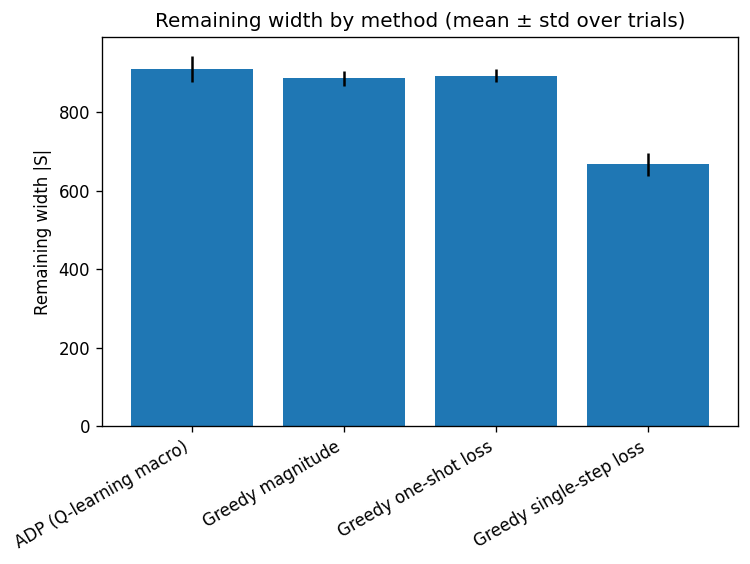

In [ ]:
# Bar chart: remaining width (mean ± std)
plt.figure()
plt.bar(summary["Method"], summary["mean_width"], yerr=summary["std_width"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Remaining width |S|")
plt.title("Remaining width by method (mean ± std over trials)")
plt.tight_layout()
plt.savefig("figures/remaining_width_bar.pdf")
plt.show()


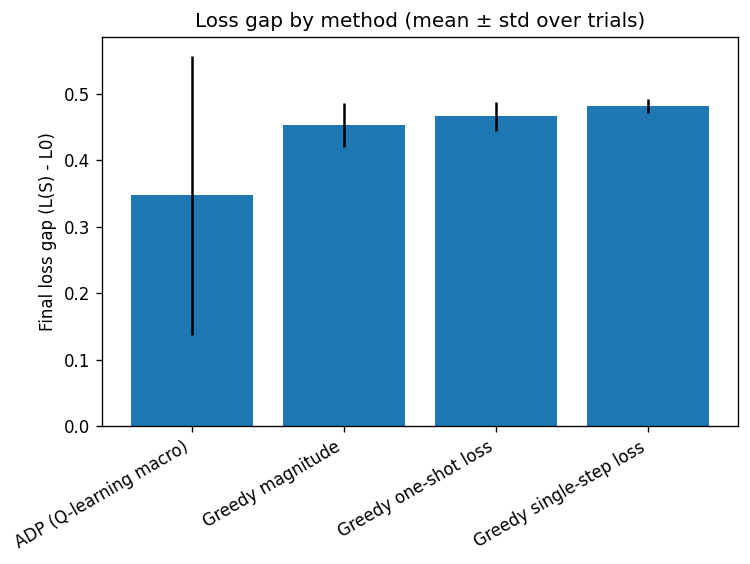

In [ ]:
# Bar chart: final loss gap relative to L0 (mean ± std)
plt.figure()
plt.bar(summary["Method"], summary["mean_gap"], yerr=summary["std_gap"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Final loss gap (L(S) - L0)")
plt.title("Loss gap by method (mean ± std over trials)")
plt.tight_layout()
plt.savefig("figures/loss_gap_bar.pdf")
plt.show()
